In [1]:
# Imports clustering models
import hdbscan

# Imports data processing and visualization libraries
from plotly.subplots import make_subplots
from sklearn.datasets import make_moons
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Imports standards
from sklearn.metrics import classification_report
from scipy.stats import mode
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")


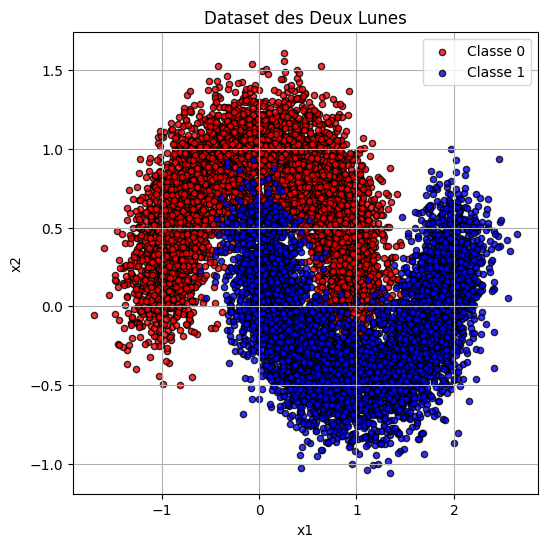

In [2]:
# Générer les données
X, y = make_moons(n_samples=10000, noise=0.2, random_state=42)
df_moons = pd.DataFrame({"x1" : X[:, 0],
                "x2" : X[:, 1],
                "label" : y})
# Visualisation avec légende
plt.figure(figsize=(6, 6))

# Affichage avec deux classes séparées
for label_val, color, label_name in zip([0, 1], ['red', 'blue'], ['Classe 0', 'Classe 1']):
    subset = df_moons[df_moons["label"] == label_val]
    plt.scatter(subset["x1"], subset["x2"], color=color, edgecolors='k', label=label_name, alpha=0.8, s=20)

plt.title("Dataset des Deux Lunes")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()


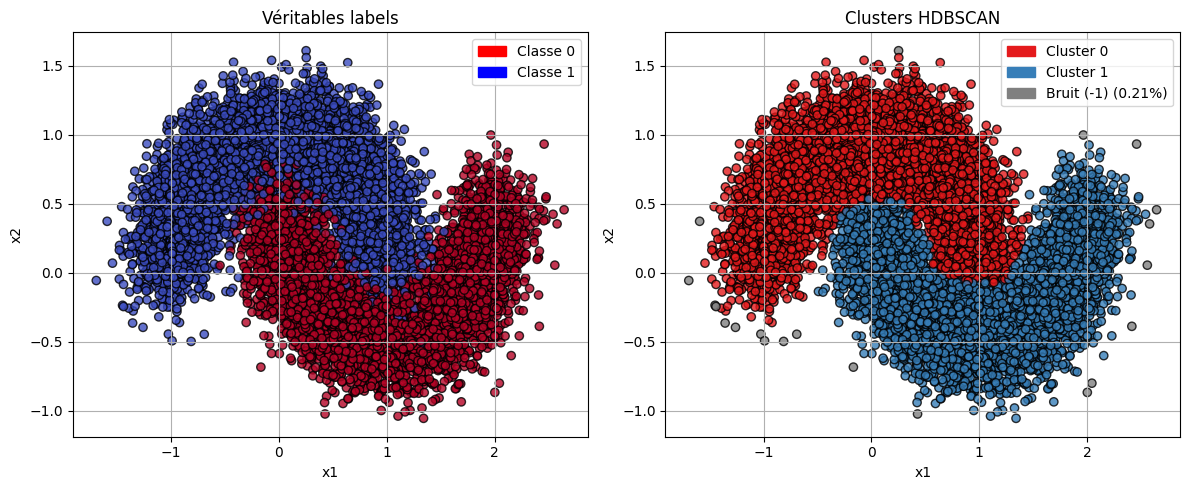

In [3]:
# Création du clusterer HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=99)

# Fit & prédiction
hdbscan_labels = clusterer.fit_predict(X)

# Ajout au DataFrame
df_moons["hdbscan_label"] = hdbscan_labels


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Vrais labels
axes[0].scatter(df_moons["x1"], df_moons["x2"],
                c=df_moons["label"], cmap='coolwarm',
                edgecolors='k', alpha=0.8)
axes[0].set_title("Véritables labels")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].grid(True)
axes[0].legend(handles=[
    mpatches.Patch(color='red', label='Classe 0'),
    mpatches.Patch(color='blue', label='Classe 1')
])

# Clusters HDBSCAN
colors = df_moons["hdbscan_label"].map(lambda x: 'gray' if x == -1 else plt.cm.Set1(x))
axes[1].scatter(df_moons["x1"], df_moons["x2"],
                color=colors, edgecolors='k', alpha=0.8)
axes[1].set_title("Clusters HDBSCAN")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")
axes[1].grid(True)

# Légende manuelle
pct_bruit = round(len(df_moons[df_moons.hdbscan_label == -1])/len(df_moons) * 100, 2)

legend_elements = [
    mpatches.Patch(color=plt.cm.Set1(0), label='Cluster 0'),
    mpatches.Patch(color=plt.cm.Set1(1), label='Cluster 1'),
    mpatches.Patch(color='gray', label=f'Bruit (-1) ({pct_bruit}%)')
]
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [4]:
y_true = df_moons["label"].to_numpy()
y_pred = df_moons["hdbscan_label"].to_numpy()

# Réalignement des labels prédits
labels_aligned = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = y_pred == cluster
    majority_label = mode(y_true[mask], keepdims=True)[0][0]
    labels_aligned[mask] = majority_label

print("Rapport de classification – Clustering Hiérarchique Agglomératif")
print(classification_report(y_true, labels_aligned, target_names=["Classe 0", "Classe 1"]))


Rapport de classification – Clustering Hiérarchique Agglomératif
              precision    recall  f1-score   support

    Classe 0       0.96      0.97      0.97      5000
    Classe 1       0.97      0.96      0.97      5000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [5]:
# (1) Calcul des résultats
min_samples_range = list(range(1, 1000))
results = []
for ms in min_samples_range:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=100,
        min_samples=ms,
        metric='euclidean',
        prediction_data=True
    )
    labels = clusterer.fit_predict(X)
    n_clusters = len(set(labels) - {-1})
    noise_pct = np.mean(labels == -1) * 100
    avg_persistence = (np.median(clusterer.cluster_persistence_)
                       if clusterer.cluster_persistence_.size > 0 else 0)
    results.append({
        'min_samples': ms,
        'n_clusters': n_clusters,
        'noise_pct': noise_pct,
        'avg_persistence': avg_persistence
    })
df = pd.DataFrame(results)

# (2) Création de la figure interactive
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Trace 1 : nombre de clusters
fig.add_trace(
    go.Scatter(
        x=df['min_samples'],
        y=df['n_clusters'],
        mode='lines+markers',
        name='Nombre de clusters'
    ),
    secondary_y=False
)

# Trace 2 : pourcentage de bruit
fig.add_trace(
    go.Scatter(
        x=df['min_samples'],
        y=df['noise_pct'],
        mode='lines+markers',
        name='% de bruit'
    ),
    secondary_y=False
)

# Trace 3 : persistance moyenne
fig.add_trace(
    go.Scatter(
        x=df['min_samples'],
        y=df['avg_persistence'],
        mode='lines+markers',
        name='Persistance avg.',
        marker_symbol='triangle-up'
    ),
    secondary_y=True
)

# (3) Mise en forme des axes et du layout
fig.update_layout(
    title='Sensibilité de HDBSCAN à min_samples',
    xaxis_title='min_samples',
    legend=dict(x=0.01, y=0.99),
    width=1400, height=700
)
fig.update_yaxes(title_text='Clusters / % bruit', secondary_y=False)
fig.update_yaxes(title_text='Persistance moyenne', secondary_y=True)

# (4) Affichage
fig.show()


In [6]:
df[df.noise_pct < 1]

,min_samples,n_clusters,noise_pct,avg_persistence
90,91,2,0.30,0.529726
98,99,2,0.21,0.540035
117,118,2,0.28,0.523544


In [11]:
# Applique ACP sur la meme base macron cocaine
import sys
from pathlib import Path

# Ajouter automatiquement le dossier racine du projet au sys.path
root_dir = Path().resolve().parent  # remonte à la racine
if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))

# Imports standards
from sentence_transformers import SentenceTransformer
from utils.helper_functions import clean_text
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import umap
import time
import os

warnings.filterwarnings("ignore")



file_path = root_dir/Path("data/importation-635-focus-AI.csv")
df = pd.read_csv(file_path, sep=";")
df = df[["sentences"]]
texts = (df.sentences.apply(lambda x: clean_text(x))).to_list()

In [12]:
model_embedding = "all-mpnet-base-v2"
model = SentenceTransformer(model_embedding, device="cuda")  
# Encode the texts
embeddings = model.encode(texts, show_progress_bar=True, batch_size=256)
df["embeddings"] = embeddings.tolist()

shape_before_deduplication = len(df["embeddings"])
df = df.drop_duplicates(subset="embeddings", keep="first") 
embeddings = np.vstack(df["embeddings"].to_numpy())

print("We have deduplicated the embeddings, reducing the dataset from", shape_before_deduplication, "to", len(df["embeddings"]), "that means we have removed", round((shape_before_deduplication - len(df["embeddings"]))*100/shape_before_deduplication, 2),"% of initial data.")

Batches: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

We have deduplicated the embeddings, reducing the dataset from 1853 to 1217 that means we have removed 34.32 % of initial data.


In [13]:
# Fit the UMAP model on your embeddings
start = time.time()
reducer = umap.UMAP(n_components=2, random_state=123).fit(embeddings)
# Transform the embeddings to 2D
reduced_embeddings = reducer.transform(embeddings)
end = time.time()
print(f"UMAP took {end - start:.2f} seconds to reduce the embeddings to 2D.")

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {reduced_embeddings.shape}")

df['x_umap'] = reduced_embeddings[:,0]
df['y_umap'] = reduced_embeddings[:,1]
umap_time = end - start

UMAP took 8.37 seconds to reduce the embeddings to 2D.
Reduced embeddings shape: (1217, 2)


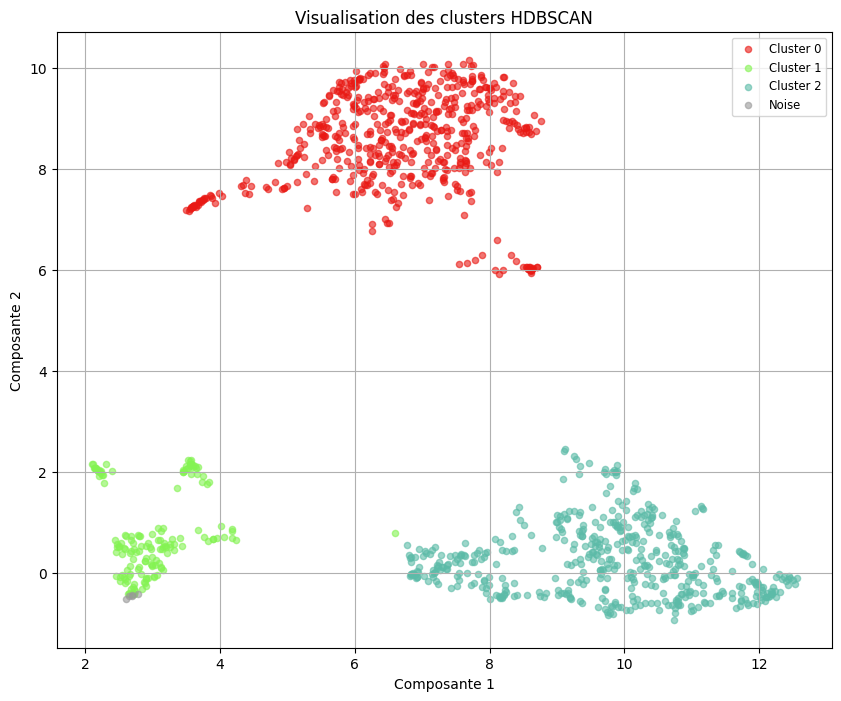

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import hdbscan
from matplotlib.colors import rgb2hex
import random

parameters_hdbscan = {
    "min_cluster_size":100,
    "min_samples": 118,
    "cluster_selection_method": "eom",
    "metric": "euclidean",
    "prediction_data" : True,
}
run_soft_clustering = False
clusterer = hdbscan.HDBSCAN(**parameters_hdbscan).fit(reduced_embeddings)
df['cluster'] = clusterer.labels_
cluster_labels = clusterer.labels_
# Générer une couleur unique pour chaque cluster
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
colors = [rgb2hex([random.random(), random.random(), random.random()]) for _ in range(num_clusters)]
color_map = {label: colors[i] if label != -1 else '#999999' for i, label in enumerate(set(cluster_labels))}

# Créer le scatter plot
plt.figure(figsize=(10, 8))
for label in set(cluster_labels):
    mask = cluster_labels == label
    plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1],
                c=color_map[label], label=f'Cluster {label}' if label != -1 else 'Noise',
                s=20, alpha=0.6)

plt.title('Visualisation des clusters HDBSCAN')
plt.legend(loc='best', fontsize='small')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.grid(True)
plt.show()


In [163]:
pd.DataFrame(results)

,min_samples,n_clusters,noise_pct,avg_persistence
0,1,5,26.04,0.075705
1,2,5,27.78,0.076892
2,3,9,41.76,0.058928
3,4,3,34.89,0.066456
4,5,3,36.72,0.064515
...,...,...,...,...
994,995,2,60.99,0.045929
995,996,2,61.00,0.045863
996,997,2,61.20,0.045831
997,998,2,61.41,0.045506


In [10]:
df

,min_samples,n_clusters,noise_pct,avg_persistence
0,1,5,26.04,0.075705
1,2,5,27.78,0.076892
2,3,9,41.76,0.058928
3,4,3,34.89,0.066456
4,5,3,36.72,0.064515
...,...,...,...,...
994,995,2,60.99,0.045929
995,996,2,61.00,0.045863
996,997,2,61.20,0.045831
997,998,2,61.41,0.045506


In [177]:
import numpy as np
import pandas as pd
import hdbscan
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Assuming df contains the data with UMAP coordinates
XX = df[["x_umap", "y_umap"]].to_numpy()



# (1) Calcul des résultats
min_samples_range = list(range(1, 200))
results = []
for ms in min_samples_range:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=100,
        min_samples=ms,
        metric='euclidean',
        prediction_data=True
    )
    labels = clusterer.fit_predict(XX)
    n_clusters = len(set(labels) - {-1})
    noise_pct = np.mean(labels == -1) * 100
    avg_persistence = (np.median(clusterer.cluster_persistence_)
                       if clusterer.cluster_persistence_.size > 0 else 0)
    results.append({
        'min_samples': ms,
        'n_clusters': n_clusters,
        'noise_pct': noise_pct,
        'avg_persistence': avg_persistence
    })
df_results2 = pd.DataFrame(results)

# (2) Création de la figure interactive
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Trace 1 : nombre de clusters
fig.add_trace(
    go.Scatter(
        x=df_results2['min_samples'],
        y=df_results2['n_clusters'],
        mode='lines+markers',
        name='Nombre de clusters'
    ),
    secondary_y=False
)

# Trace 2 : pourcentage de bruit
fig.add_trace(
    go.Scatter(
        x=df_results2['min_samples'],
        y=df_results2['noise_pct'],
        mode='lines+markers',
        name='% de bruit'
    ),
    secondary_y=False
)

# Trace 3 : persistance moyenne
fig.add_trace(
    go.Scatter(
        x=df_results2['min_samples'],
        y=df_results2['avg_persistence'],
        mode='lines+markers',
        name='Persistance avg.',
        marker_symbol='triangle-up'
    ),
    secondary_y=True
)

# (3) Mise en forme des axes et du layout
fig.update_layout(
    title='Sensibilité de HDBSCAN à min_samples',
    xaxis_title='min_samples',
    legend=dict(x=0.01, y=0.99),
    width=1400, height=700
)
fig.update_yaxes(title_text='Clusters / % bruit', secondary_y=False)
fig.update_yaxes(title_text='Persistance moyenne', secondary_y=True)

# (4) Affichage
fig.show()
